# Continuous Hopfield Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import pysindy as ps
from sklearn.metrics import r2_score, mean_squared_error
import scienceplots
plt.style.use(["science", "notebook", "grid"])

In [2]:
# def hopfield2d_sigmoid(t, x, weights = [1, -1]):
#     # weights = [J_12, J_21]
#     return [-x[0] + 1 / (1 + np.exp(- weights[0] * x[1])),
#             -x[1] + 1 / (1 + np.exp(- weights[1] * x[0]))]

In [3]:
def hopfield2d(t, x, weights=np.array([1, -1]), activation_type="sigmoid"):
    # weights = [J_12, J_21]
    
    try:
        if activation_type == "sigmoid":
            return [-x[0] + 1 / (1 + np.exp(- weights[0] * x[1])),
                    -x[1] + 1 / (1 + np.exp(- weights[1] * x[0]))]
            
        elif activation_type == "tanh":
            return [1/2 - x[0] + (1/2)*np.tanh(weights[0] * x[1]),
                    1/2 - x[1] + (1/2)*np.tanh(weights[1] * x[0])]
            
        else:
            raise ValueError("Invalid activation type. Must be 'sigmoid' or 'tanh'.")

    except TypeError:
        raise Exception("Input must be a string for the activation_type argument and numpy.ndarray for weights.")

In [4]:
# solution = fsolve(hopfield2d, (1, 0.5), full_output=1) # remove t from inputs of hopfield2d to run (only for this)
# solution

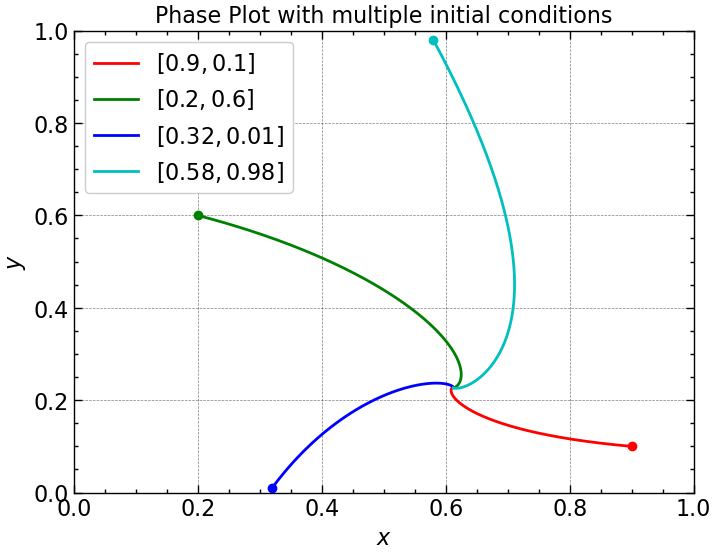

In [5]:
initial_conditions = [[0.9, 0.1], [0.2, 0.6], [0.32, 0.01], [0.58, 0.98]]
delta_t = 0.01
t = np.arange(0, 30, delta_t)
colors = ['r', 'g', 'b', 'c']  # Define colors for the lines

plt.figure(figsize=(8, 6))

for i, x0 in enumerate(initial_conditions):
    np.random.seed(42)
    x_train = solve_ivp(lambda t, x: hopfield2d(t, x, activation_type="tanh"), (t[0], t[-1]), x0, t_eval=t, rtol=1e-12, method="LSODA", atol=1e-12).y.T
    x = x_train[:, 0]
    y = x_train[:, 1]
    plt.plot(x, y, color=colors[i], label=f"${x0}$")
    plt.scatter(x0[0], x0[1], color=colors[i], marker='o')  # Plot initial condition point with the same color

# plt.plot(0.58831902, 0.35702064, 'ko', markersize=8)
# plt.text(0.59, 0.37, "fixed point", fontsize = 10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Phase Plot with multiple initial conditions")
plt.legend()
plt.show()

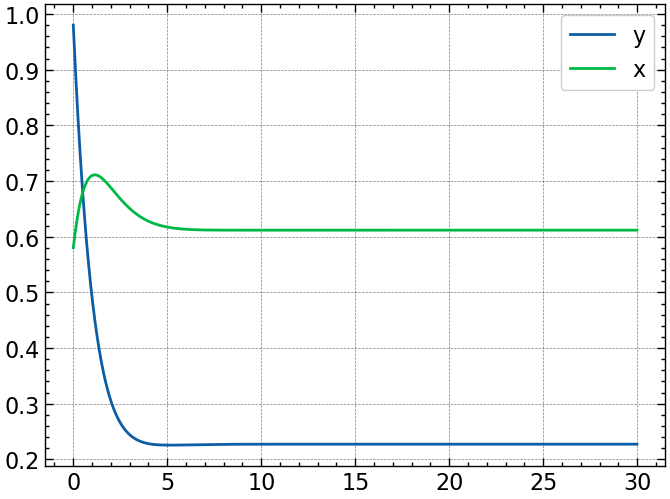

In [6]:
plt.plot(t, y, label = "y")
plt.plot(t, x, label = "x")
plt.legend()
plt.show()

In [7]:
# 2D model
delta_t = 0.01
t = np.arange(0, 30, delta_t)
x0 = [0.2, 0.6]

# library
lib1 = ps.PolynomialLibrary(degree=1) # bias included by default
# tanh library
functions_tanh = [lambda x: np.tanh(x), lambda x: np.tanh(-x)]
functions_names_tanh = [lambda x: "tanh(" + x + ")", lambda x: "tanh(-" + x + ")"]
lib2_tanh = ps.CustomLibrary(library_functions=functions_tanh, function_names=functions_names_tanh)
lib_tanh = ps.GeneralizedLibrary([lib1, lib2_tanh])
# sigmoid library
functions_sig = [lambda x: 1 / (1 + np.exp(-x)), lambda x: 1 / (1 + np.exp(x))]
functions_names_sig = [lambda x: "1/(1+exp(-" + x + "))", lambda x: "1/(1+exp(" + x + "))"]
lib2_sig = ps.CustomLibrary(library_functions=functions_sig, function_names=functions_names_sig)
lib_sig = ps.GeneralizedLibrary([lib1, lib2_sig])

# optimization and diffferentiation method
opt = ps.STLSQ(threshold=0.01)
diff = ps.FiniteDifference()
features = ["x1", "x2"]

# models = {}
# models_sim = {}
# models_score = {}
# true_xy = {} # x,y values of the correct model

weights = [[1, -1], [-1, 1], [1, 1], [-1, -1]]
activations = ["sigmoid", "tanh"]

# for weight in weights:
#     weight = np.array(weight)
#     for activation in activations:
#         np.random.seed(42)
#         x_train = solve_ivp(lambda t, x: hopfield2d(t, x, weights=weight, activation_type=activation), (t[0], t[-1]), x0, t_eval=t, rtol=1e-12, method="LSODA", atol=1e-12).y.T
#         x_dot = np.array([hopfield2d(0, x_train[t]) for t in range(t.size)])
#         x = x_train[:, 0]
#         y = x_train[:, 1]
#         true_xy[f"{weight} {activation}"] = [x, y]
#         if activation == "sigmoid":
#             lib = lib_sig
#         elif activation == "tanh":
#             lib = lib_tanh
#         model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=diff, feature_names=features)
#         model.fit(x_train, t, x_dot)
#         models[f"{weight} {activation}"] = model
#         models_sim[f"{weight} {activation}"] = model.simulate(x0, t)
        
#         r2 = model.score(x_train, t, x_dot, metric=r2_score)
#         mse = model.score(x_train, t, x_dot, metric=mean_squared_error)
#         models_score[f"{weight} {activation}"] = [r2, mse]

In [8]:
# for model_key, model in models.items():
#     print(f"{model_key}:")
#     model.print()

In [9]:
def plot_phase_plane(x, y, model_sim_x, model_sim_y, x0, title=""):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, c="k", label="True")
    plt.plot(model_sim_x, model_sim_y, "r--", label="SINDy")
    plt.scatter(x0[0], x0[1], c="k", s=15)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend()
    plt.title(f"Phase plane {title}")
    plt.show()

def plot_time_series(t, x, y, model_sim_x, model_sim_y, title=""):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    axes[0].plot(t, x, label='True', c="k")
    axes[0].plot(t, model_sim_x, "r--", label='SINDy')
    axes[0].set_ylabel('$x$', fontsize=15)
    axes[0].legend(loc="lower right", prop={'size': 10})
    axes[0].xaxis.set_ticklabels([])
    axes[0].yaxis.set_tick_params(labelsize=10)

    axes[1].plot(t, y, label='True', c="k")
    axes[1].plot(t, model_sim_y, "r--", label='SINDy')
    axes[1].set_ylabel('$y$', fontsize=15)
    axes[1].xaxis.set_tick_params(labelsize=10)
    axes[1].yaxis.set_tick_params(labelsize=10)
    plt.suptitle(f"True vs SINDy in $(x,y)$ {title}")
    plt.tight_layout()
    plt.show()

In [10]:
def simulate_model(weight, activation, lib):
    x_train = solve_ivp(lambda t, x: hopfield2d(t, x, weights=weight, activation_type=activation), (t[0], t[-1]), x0, t_eval=t, rtol=1e-12, method="LSODA", atol=1e-12).y.T
    x_dot = np.array([hopfield2d(0, x_train[t], weights=weight, activation_type=activation) for t in range(t.size)])
    x = x_train[:, 0]
    y = x_train[:, 1]
    model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=diff, feature_names=features)
    model.fit(x_train, t, x_dot)
    model_sim = model.simulate(x0, t)
    model_sim_x = model_sim[:, 0]
    model_sim_y = model_sim[:, 1]
    r2 = model.score(x_train, t, x_dot, metric=r2_score)
    mse = model.score(x_train, t, x_dot, metric=mean_squared_error)
    
    return model, x, y, model_sim_x, model_sim_y, r2, mse

# Sigmoid 

In [11]:
# activation = activations[0] # sigmoid
# lib = lib_sig

In [12]:
# weight = np.array(weights[0])

# model_1, x_1, y_1, model_sim_x_1, model_sim_y_1, r2_1, mse_1 = simulate_model(weight, activation, lib)
# model_1.print()
# print(f"R2: {r2_1}\tMSE: {round(mse_1,3)}")
# plot_phase_plane(x_1, y_1, model_sim_x_1, model_sim_y_1, x0)
# plot_time_series(t, x_1, y_1, model_sim_x_1, model_sim_y_1)

In [13]:
# weight = np.array(weights[1])

# model_2, x_2, y_2, model_sim_x_2, model_sim_y_2, r2_2, mse_2 = simulate_model(weight, activation, lib)
# model_2.print()
# print(f"R2: {r2_2}\tMSE: {round(mse_2,3)}")
# plot_phase_plane(x_2, y_2, model_sim_x_2, model_sim_y_2, x0)
# plot_time_series(t, x_2, y_2, model_sim_x_2, model_sim_y_2)

In [14]:
# weight = np.array(weights[2])

# model_3, x_3, y_3, model_sim_x_3, model_sim_y_3, r2_3, mse_3 = simulate_model(weight, activation, lib)
# model_3.print()
# print(f"R2: {r2_3}\tMSE: {round(mse_3,3)}")
# plot_phase_plane(x_3, y_3, model_sim_x_3, model_sim_y_3, x0)
# plot_time_series(t, x_3, y_3, model_sim_x_3, model_sim_y_3)

Model with J_12=1, J_21=-1	Activation sigmoid
(x1)' = 0.250 1 + -1.000 x1 + 0.125 1/(1+exp(-x1)) + 0.625 1/(1+exp(-x2)) + 0.125 1/(1+exp(x1)) + -0.375 1/(1+exp(x2))
(x2)' = 0.250 1 + -1.000 x2 + -0.375 1/(1+exp(-x1)) + 0.125 1/(1+exp(-x2)) + 0.625 1/(1+exp(x1)) + 0.125 1/(1+exp(x2))
R2: 1.0	MSE: 0.0


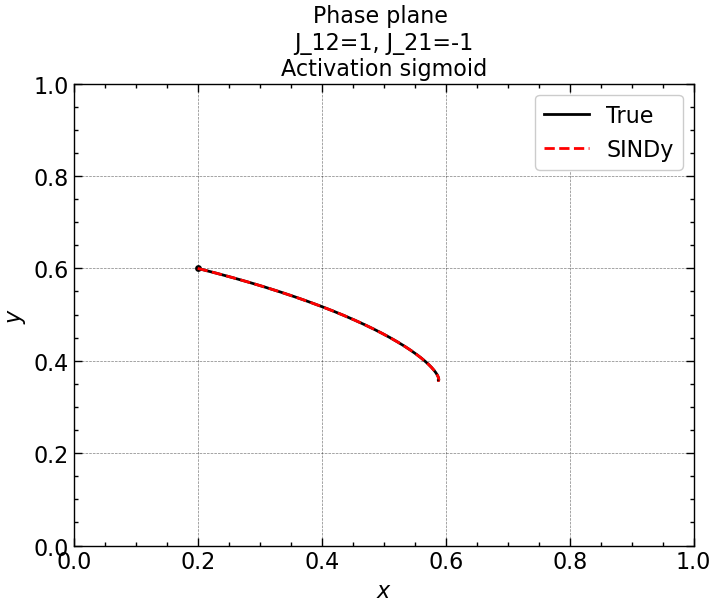

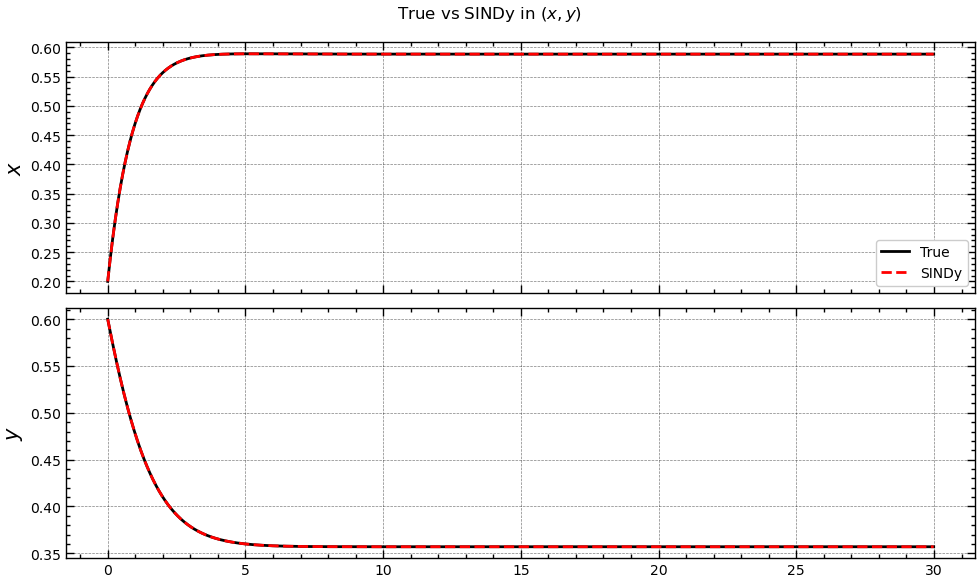

Model with J_12=-1, J_21=1	Activation sigmoid
(x1)' = 0.250 1 + -1.000 x1 + 0.125 1/(1+exp(-x1)) + -0.375 1/(1+exp(-x2)) + 0.125 1/(1+exp(x1)) + 0.625 1/(1+exp(x2))
(x2)' = 0.250 1 + -1.000 x2 + 0.625 1/(1+exp(-x1)) + 0.125 1/(1+exp(-x2)) + -0.375 1/(1+exp(x1)) + 0.125 1/(1+exp(x2))
R2: 1.0	MSE: 0.0


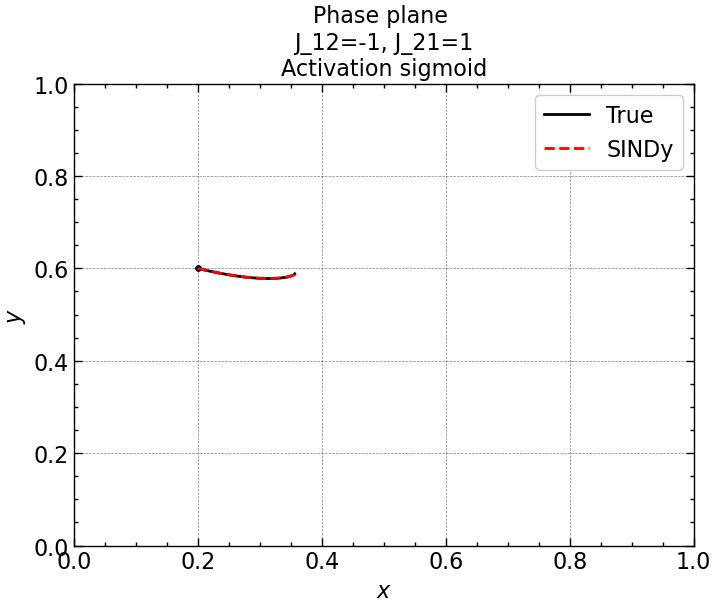

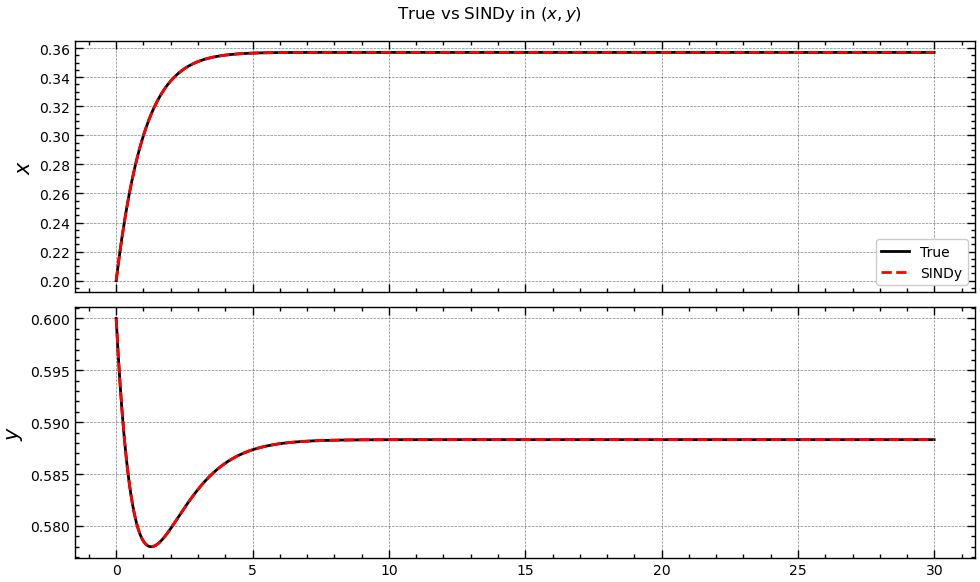

Model with J_12=1, J_21=1	Activation sigmoid
(x1)' = 0.250 1 + -1.000 x1 + 0.125 1/(1+exp(-x1)) + 0.625 1/(1+exp(-x2)) + 0.125 1/(1+exp(x1)) + -0.375 1/(1+exp(x2))
(x2)' = 0.250 1 + -1.000 x2 + 0.625 1/(1+exp(-x1)) + 0.125 1/(1+exp(-x2)) + -0.375 1/(1+exp(x1)) + 0.125 1/(1+exp(x2))
R2: 1.0	MSE: 0.0


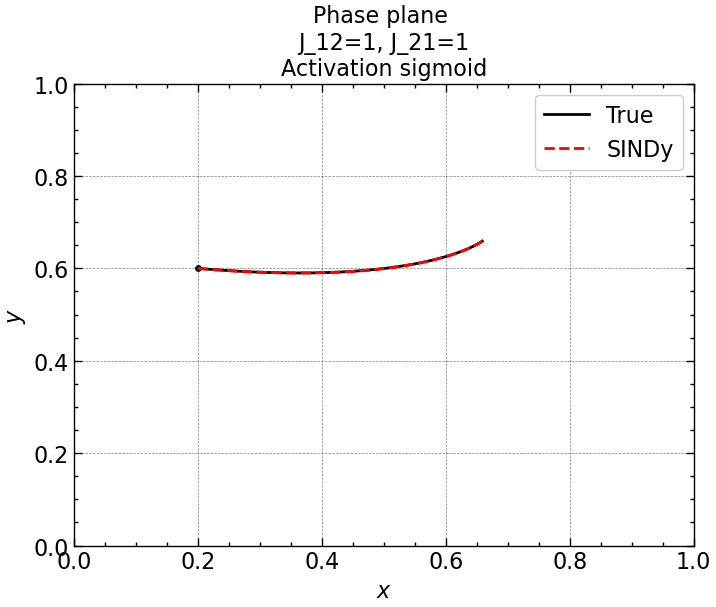

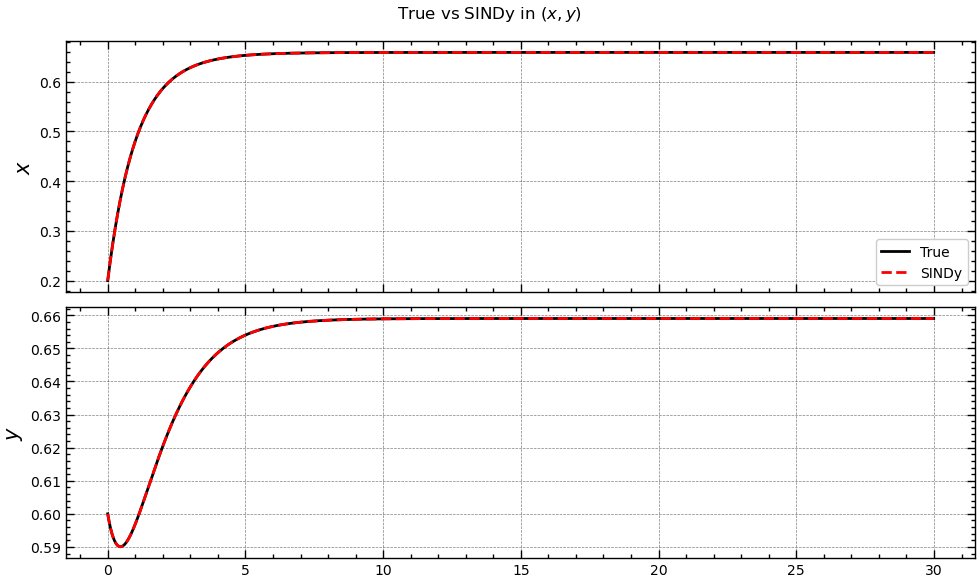

Model with J_12=-1, J_21=-1	Activation sigmoid
(x1)' = -1.000 x1 + 0.250 1/(1+exp(-x1)) + -0.250 1/(1+exp(-x2)) + 0.250 1/(1+exp(x1)) + 0.750 1/(1+exp(x2))
(x2)' = -1.000 x2 + -0.250 1/(1+exp(-x1)) + 0.250 1/(1+exp(-x2)) + 0.750 1/(1+exp(x1)) + 0.250 1/(1+exp(x2))
R2: 1.0	MSE: 0.0


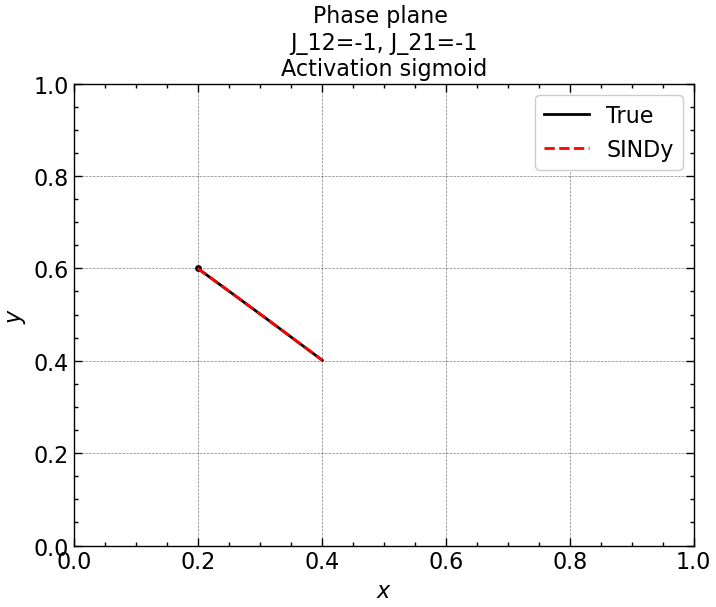

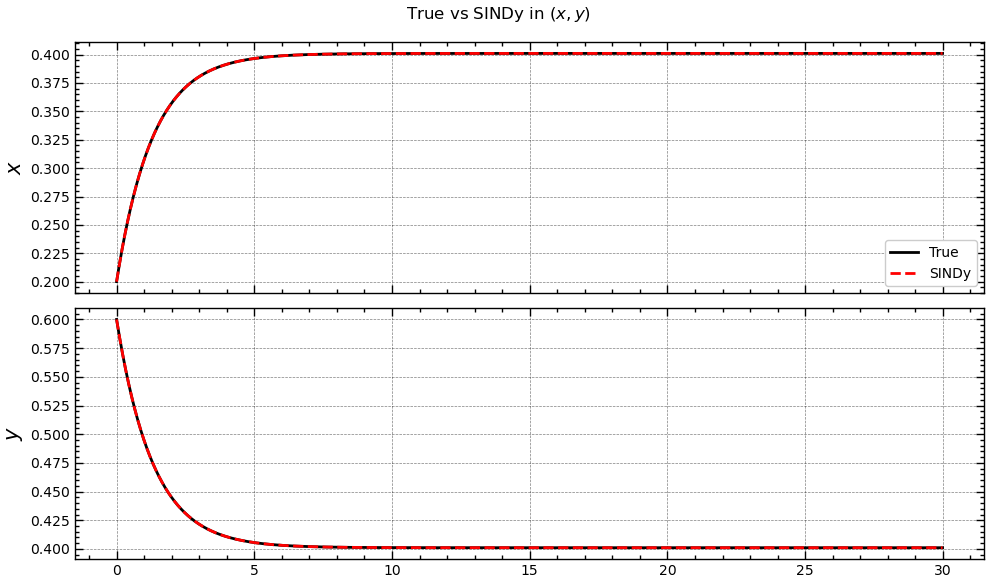

Model with J_12=1, J_21=-1	Activation tanh
(x1)' = 0.500 1 + -1.000 x1 + 0.250 tanh(x2) + -0.250 tanh(-x2)
(x2)' = 0.500 1 + -1.000 x2 + -0.250 tanh(x1) + 0.250 tanh(-x1)
R2: 1.0	MSE: 0.0


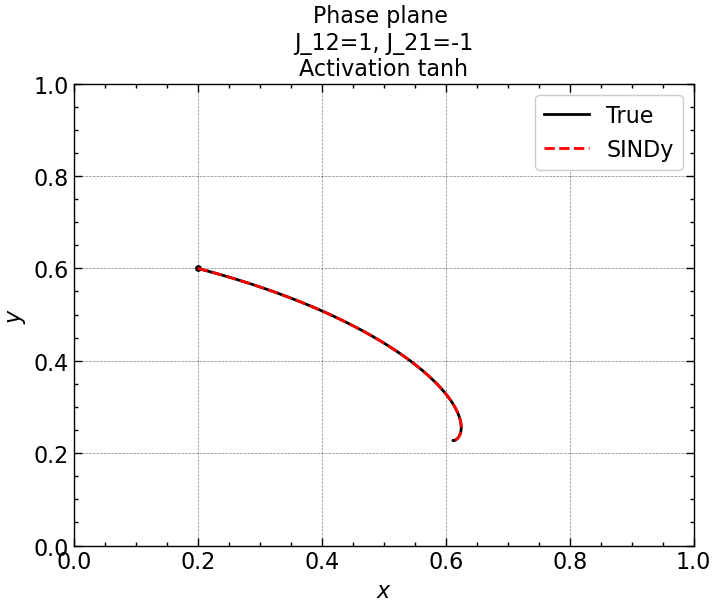

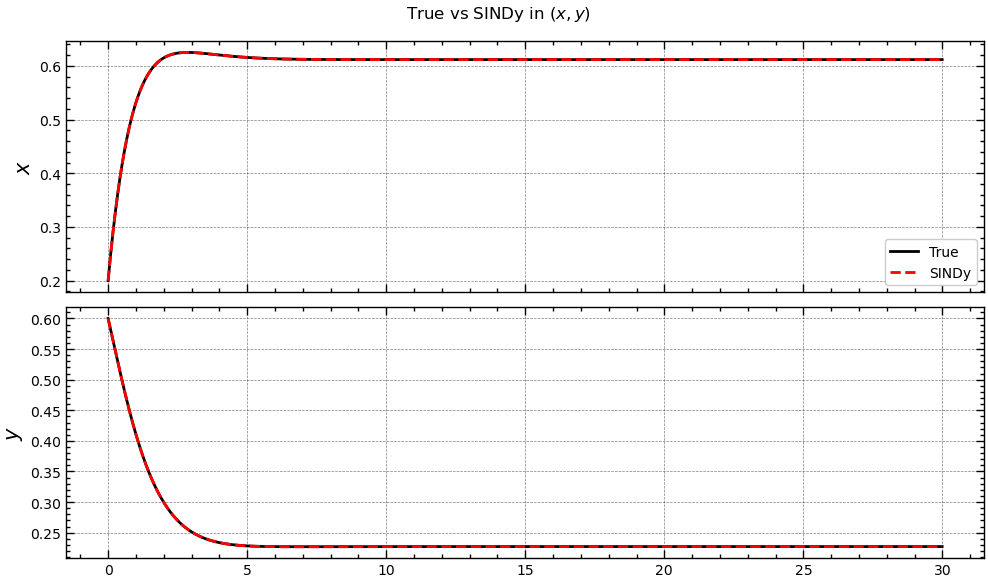

Model with J_12=-1, J_21=1	Activation tanh
(x1)' = 0.500 1 + -1.000 x1 + -0.250 tanh(x2) + 0.250 tanh(-x2)
(x2)' = 0.500 1 + -1.000 x2 + 0.250 tanh(x1) + -0.250 tanh(-x1)
R2: 1.0	MSE: 0.0


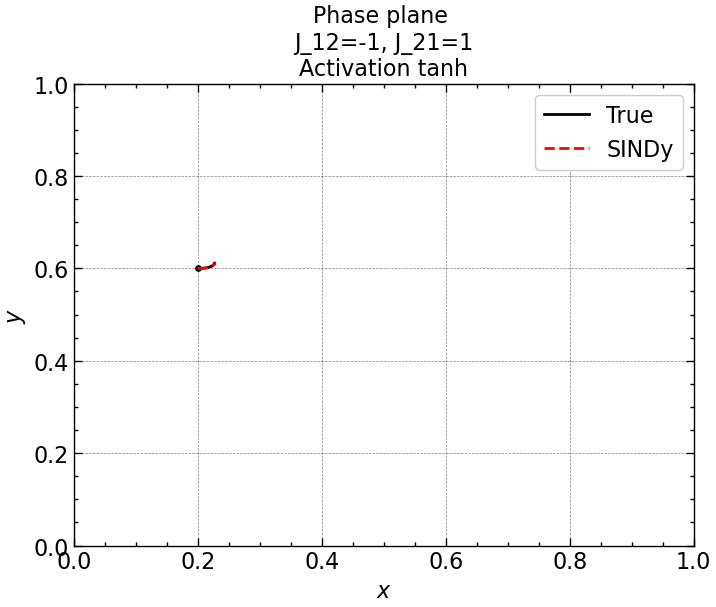

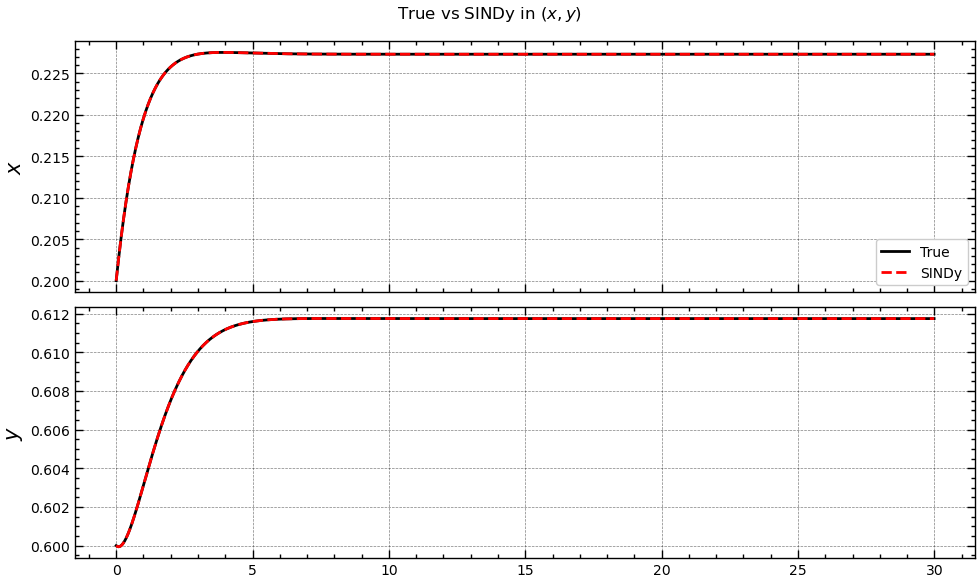

Model with J_12=1, J_21=1	Activation tanh
(x1)' = 0.500 1 + -1.000 x1 + 0.250 tanh(x2) + -0.250 tanh(-x2)
(x2)' = 0.500 1 + -1.000 x2 + 0.250 tanh(x1) + -0.250 tanh(-x1)
R2: 1.0	MSE: 0.0


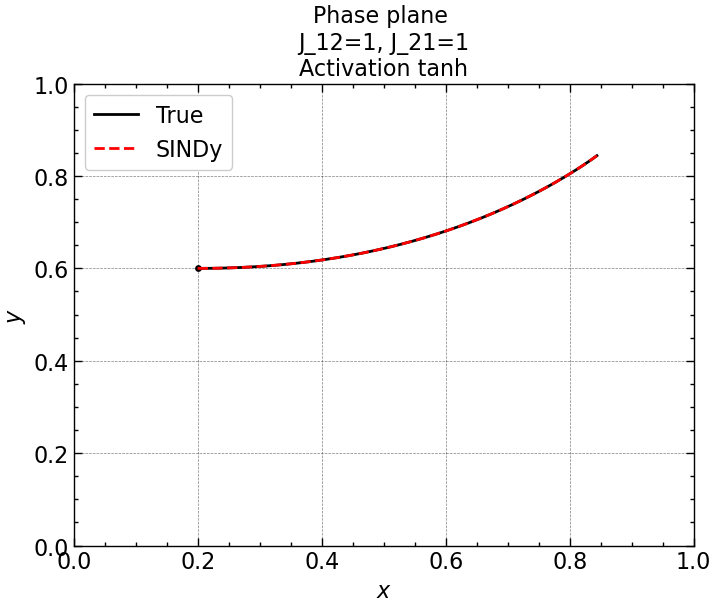

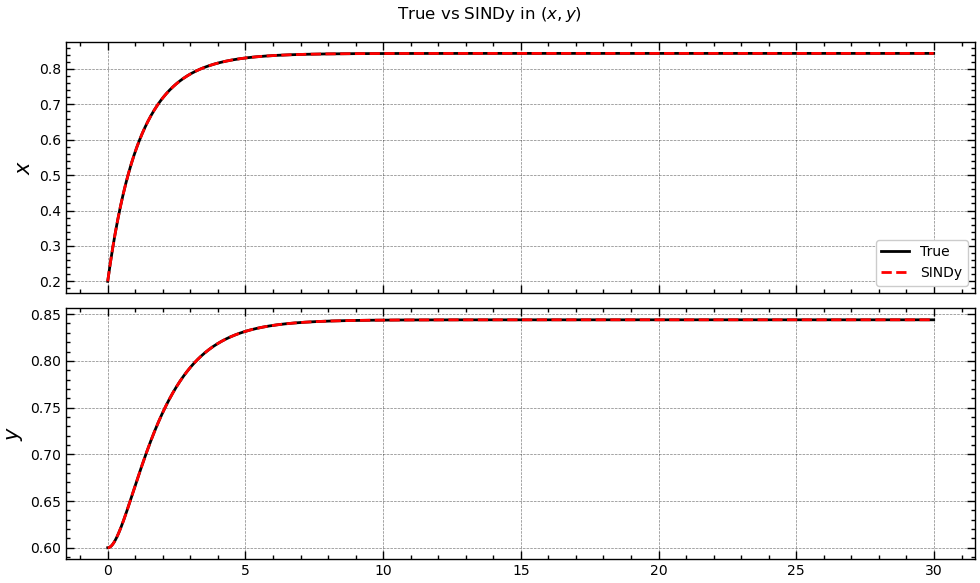

Model with J_12=-1, J_21=-1	Activation tanh
(x1)' = 0.409 1 + -1.310 x1 + -0.344 x2 + 0.229 tanh(x1) + -0.229 tanh(-x1)
(x2)' = 0.500 1 + -1.000 x2 + -0.250 tanh(x1) + 0.250 tanh(-x1)
R2: 0.9999988000576877	MSE: 0.0


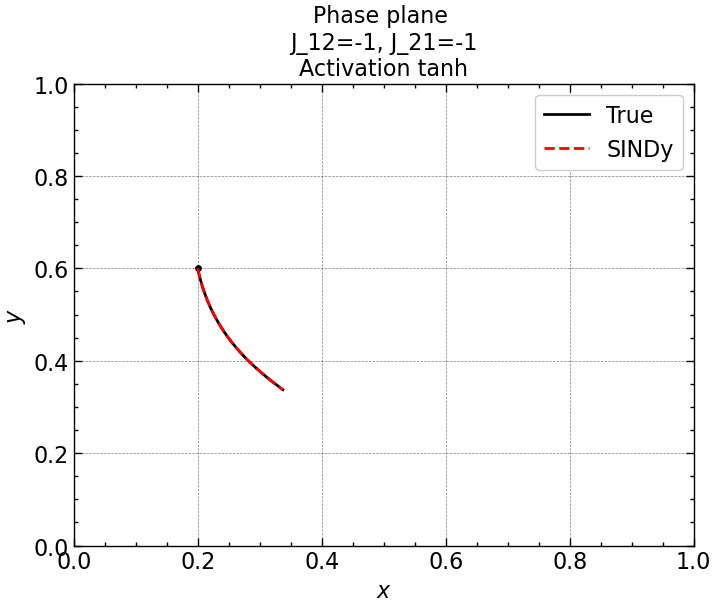

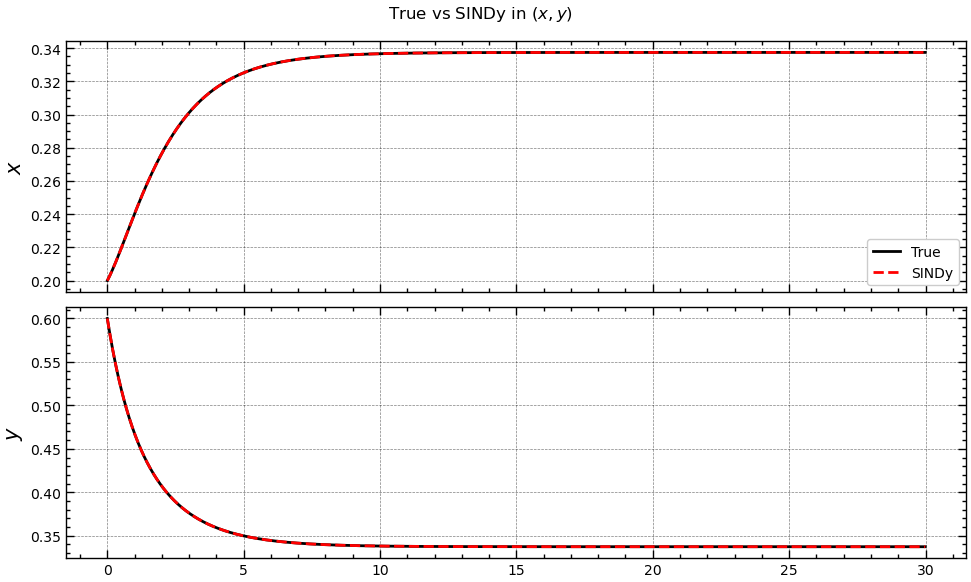

In [15]:
i = 0
for activation in activations:
    
    if activation == "sigmoid":
        lib = lib_sig
    elif activation == "tanh":
        lib = lib_tanh
        
    for weight in weights:
        print(f"Model with J_12={weight[0]}, J_21={weight[1]}\tActivation {activation}")
        model, x, y, model_sim_x, model_sim_y, r2, mse = simulate_model(weight, activation, lib)
        model.print()
        print(f"R2: {r2}\tMSE: {round(mse,3)}")
        plot_phase_plane(x, y, model_sim_x, model_sim_y, x0, title = f"\nJ_12={weight[0]}, J_21={weight[1]}\nActivation {activation}")
        plot_time_series(t, x, y, model_sim_x, model_sim_y)
        i += 1